<a href="https://colab.research.google.com/github/sahilk45/LLMs-Nuts-n-Bolts/blob/main/GPT_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
GPT_CONFIG_124M={
    "vocab_size":50257,
    "context_length":1024,
    "emb_dim":768,
    "n_heads":12,    #No. of attention heads
    "n_layers":12,    #No. of transformer layers
    "drop_rate":0.1,
    "qkv_bias":False
}

# **PART1: Dummy GPT Model Class**

In [ ]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])  #len as vocab size and breadth as embedding dim:[]
    self.pos_embedding = nn.Embedding(cfg["context_length"],cfg["emb_dim"]) #context len beac pos embedding req from 0 to context_len only, as after that next row input comes
    self.drop_emb=nn.Dropout(cfg["drop_rate"])

    # Use a placeholder for TransformerBlock
    self.trf_blocks = nn.Sequential(
        *[DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    # Use a placeholder for LayerNorm
    self.final_norm = DummyLayerNorm(cfg["emb_dim"])
    self.out_head = nn.Linear(
          cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape
    tok_embeds=self.tok_emb(in_idx)
    pos_embeds=self.pos_embedding(torch.arange(seq_len,device=in_idx.device)) #so that pos_embed tensor is created on same device as in_idx so addition later works
    x=tok_embeds+pos_embeds
    x=self.drop_emb(x)
    x=self.trf_blocks(x)
    x=self.final_norm(x)
    logits=self.out_head(x)
    return logits


class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        # A simple placeholder

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super().__init__()
        # The parameters here are just to mimic the LayerNorm interface.

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x


**Step1: Tokenize**

In [ ]:
import tiktoken
tokenizer=tiktoken.get_encoding("gpt2")
batch=[]
text1="Every effort moves you"
text2="Every day holds a"
batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))
batch=torch.stack(batch,dim=0)
print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


**Step2: Instance of DummyGPTModel**

In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
logits = model(batch)
print("Output shape:", logits.shape)
print(logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6755, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


# **Part2: Layer Normalization**

In [ ]:
#Example
torch.manual_seed(123)
batch_example=torch.rand(2,5)
layer=nn.Sequential(nn.Linear(5,6),nn.ReLU())
out=layer(batch_example)
print(out)

tensor([[0.0000, 0.0000, 0.4091, 0.6587, 0.3914, 0.0000],
        [0.0000, 0.0000, 0.1902, 0.3182, 0.6486, 0.0000]],
       grad_fn=<ReluBackward0>)


In [ ]:
#mean and var before
mean=out.mean(dim=-1,keepdim=True) #dim=-1 as need mean col-wise,keepdim output tensor retains the same number of dimensions as the input tensor, even though the operation reduces the tensor along the dimension specified via dim.
var=out.var(dim=-1,keepdim=True)
print(mean)
print(var)

tensor([[0.2432],
        [0.1928]], grad_fn=<MeanBackward1>)
tensor([[0.0799],
        [0.0670]], grad_fn=<VarBackward0>)


In [ ]:
out_norm = (out - mean) / torch.sqrt(var)
mean = out_norm.mean(dim=-1, keepdim=True)
var = out_norm.var(dim=-1, keepdim=True)
print("Normalized layer outputs:\n", out_norm)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[-0.8603, -0.8603,  0.5869,  1.4698,  0.5242, -0.8603],
        [-0.7450, -0.7450, -0.0102,  0.4844,  1.7608, -0.7450]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[ 5.9605e-08],
        [-2.9802e-08]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


In [ ]:
torch.set_printoptions(sci_mode=False)
print("Mean:\n", mean)
print("Variance:\n", var)

Mean:
 tensor([[ 0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.],
        [1.]], grad_fn=<VarBackward0>)


**LayerNorm class**

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    var=x.var(dim=-1,keepdim=True,unbiased=False) #unbiased=false doesn't apply Bessel's correction ,which typically uses n-1 instead of n in the denominator to adjust for bias in sample variance estimation.For large-scale language models (LLMs), where the embedding dimension n is significantly large, the difference between using n and n-1 is practically negligible.
    norm_x=(x-mean)/torch.sqrt(var+self.eps)
    return self.scale *norm_x + self.shift   #The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.


In [ ]:
ln=LayerNorm(emb_dim=5)
out_ln=ln(batch_example)
mean=out_ln.mean(dim=-1,keepdim=True)
var=out_ln.var(dim=-1,keepdim=True,unbiased=False)
print("Normalized layer outputs:\n", out_ln)
print("Mean:\n", mean)
print("Variance:\n", var)

Normalized layer outputs:
 tensor([[-0.3229,  0.7049, -0.5302,  1.5069, -1.3587],
        [ 1.4247, -0.8199, -0.9248, -0.6739,  0.9940]], grad_fn=<AddBackward0>)
Mean:
 tensor([[ 0.0000],
        [-0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.9998],
        [0.9999]], grad_fn=<VarBackward0>)


# **Part3: Feed Forward NN with GELU Activation Func.**

In [ ]:
#Approx is used by GPT-2
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5*x*(1+torch.tanh(torch.sqrt(torch.tensor(2.0/torch.pi))*(x+0.044715*torch.pow(x,3))
    ))

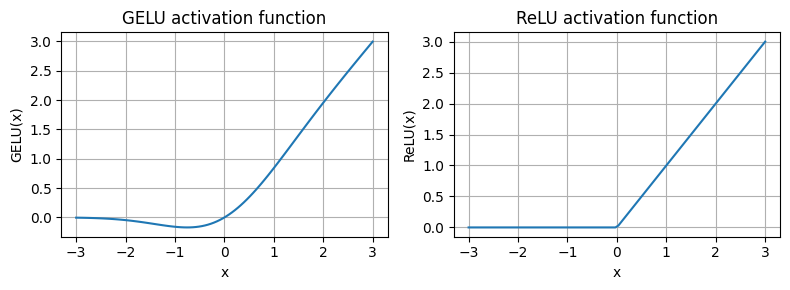

In [ ]:
import matplotlib.pyplot as plt

gelu, relu = GELU(), nn.ReLU()

# Some sample data
x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)

plt.figure(figsize=(8, 3))
for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


**FeedForwad NN Layer**

In [ ]:
class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]), #Expansion
        GELU(), #Activation
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]) #contraction
    )

  def forward(self,x):
    return self.layers(x)

In [ ]:
ffn=FeedForward(GPT_CONFIG_124M)
x=torch.rand(2,3,768)
out=ffn(x)
print(out.shape)

torch.Size([2, 3, 768])


# **Part4: Shorcut Connections**

In [ ]:
class ExampleDeepNN(nn.Module):
  def __init__(self,layer_sizes,use_shortcut):
    super().__init__()
    self.use_shortcut=use_shortcut
    self.layers=nn.ModuleList([
        nn.Sequential(nn.Linear(layer_sizes[0],layer_sizes[1]),GELU()), #nn.Sequential is designed for a strictly linear stack of operations,
        nn.Sequential(nn.Linear(layer_sizes[1], layer_sizes[2]), GELU()), #It passes the output of one module directly as the input to the next.
        nn.Sequential(nn.Linear(layer_sizes[3], layer_sizes[4]), GELU()), #It doesn't provide an easy way to insert custom logic, such as the x + layer_output for shortcut connections, between its constituent modules.
        nn.Sequential(nn.Linear(layer_sizes[2], layer_sizes[3]), GELU()),
        nn.Sequential(nn.Linear(layer_sizes[4], layer_sizes[5]), GELU())
    ])

  def forward(self,x):
    for layer in self.layers:
        # Compute the output of the current layer
        layer_output = layer(x)
        # Check if shortcut can be applied
        if self.use_shortcut and x.shape == layer_output.shape:
            x = x + layer_output
        else:
            x = layer_output
    return x

In [ ]:
layer_sizes = [3, 3, 3, 3, 3, 1]
sample_input = torch.tensor([[1., 0., -1.]])
torch.manual_seed(123)
model_without_shortcut = ExampleDeepNN(
layer_sizes, use_shortcut=False
)
print(model_without_shortcut)

ExampleDeepNN(
  (layers): ModuleList(
    (0-3): 4 x Sequential(
      (0): Linear(in_features=3, out_features=3, bias=True)
      (1): GELU()
    )
    (4): Sequential(
      (0): Linear(in_features=3, out_features=1, bias=True)
      (1): GELU()
    )
  )
)


Compute gradients in modele's backward pass

In [ ]:
def print_gradients(model, x):
    # Forward pass
    output = model(x)
    target = torch.tensor([[0.]])

    # Calculate loss based on how close the target
    # and output are
    loss = nn.MSELoss()
    loss = loss(output, target)

    # Backward pass to calculate the gradients
    loss.backward()

    for name, param in model.named_parameters():
        if 'weight' in name:
            # Print the mean absolute gradient of the weights
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")

In [ ]:
print_gradients(model_without_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.00020173584925942123
layers.1.0.weight has gradient mean of 0.00012011159560643137
layers.2.0.weight has gradient mean of 0.0007152040489017963
layers.3.0.weight has gradient mean of 0.0013988736318424344
layers.4.0.weight has gradient mean of 0.005049645435065031


With shortcut Connection

In [ ]:
torch.manual_seed(123)
model_with_shortcut = ExampleDeepNN(
layer_sizes, use_shortcut=True
)
print_gradients(model_with_shortcut, sample_input)

layers.0.0.weight has gradient mean of 0.22169792652130127
layers.1.0.weight has gradient mean of 0.20694108307361603
layers.2.0.weight has gradient mean of 0.3289699852466583
layers.3.0.weight has gradient mean of 0.2665732204914093
layers.4.0.weight has gradient mean of 1.3258541822433472


# **Part5: Attention and Linear Layers in Transformer block**

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.att=MultiHeadAttention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"] # Changed 'bias' to 'qkv_bias'
    )
    self.ff=FeedForward(cfg)
    self.norm1=LayerNorm(cfg["emb_dim"])
    self.norm2=LayerNorm(cfg["emb_dim"])
    self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    #shortcut connection for attention block
    shortcut=x
    x=self.norm1(x)   #called prelayer norm beac applied before attention and FFNN layers, original tranformation model applied this after attention layer, this leads to worse training dynamics
    x=self.att(x) # Shape [batch_size, num_tokens, emb_size]
    x=self.drop_shortcut(x)
    x=x+shortcut #Add original input back

    # Shortcut connection for feed forward block
    shortcut = x
    x = self.norm2(x)
    x = self.ff(x)
    x = self.drop_shortcut(x)
    x = x + shortcut

    return x

In [ ]:
torch.manual_seed(123)
x=torch.rand(2,4,768)
block=TransformerBlock(GPT_CONFIG_124M)
out=block(x)
print(out.shape) #Input Dimensions maintained

torch.Size([2, 4, 768])


# **Part6: GPT ModelArchitecture Implementation**

In [ ]:
class GPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.tok_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
    self.pos_emb=nn.Embedding(cfg["context_length"],cfg["emb_dim"])
    self.drop_emb=nn.Dropout(cfg["drop_rate"])

    self.trf_blocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

    self.final_norm=LayerNorm(cfg["emb_dim"])
    self.out_head=nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape
    tok_embeds=self.tok_emb(in_idx)
    pos_embeds=self.pos_emb(torch.arange(seq_len,device=in_idx.device))
    x=tok_embeds+pos_embeds # Shape [batch_size, num_tokens, emb_size]
    x=self.drop_emb(x)
    x=self.trf_blocks(x)
    x=self.final_norm(x)
    logits=self.out_head(x)
    return logits

In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
out = model(batch)
print("Input batch:\n", batch)
print("\nOutput shape:", out.shape)
print(out)

Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.3613,  0.4222, -0.0711,  ...,  0.3483,  0.4661, -0.2838],
         [-0.1792, -0.5660, -0.9485,  ...,  0.0477,  0.5181, -0.3168],
         [ 0.7120,  0.0332,  0.1085,  ...,  0.1018, -0.4327, -0.2553],
         [-1.0076,  0.3418, -0.1190,  ...,  0.7195,  0.4023,  0.0532]],

        [[-0.2564,  0.0900,  0.0335,  ...,  0.2659,  0.4454, -0.6806],
         [ 0.1230,  0.3653, -0.2074,  ...,  0.7705,  0.2710,  0.2246],
         [ 1.0558,  1.0318, -0.2800,  ...,  0.6936,  0.3205, -0.3178],
         [-0.1565,  0.3926,  0.3288,  ...,  1.2630, -0.1858,  0.0388]]],
       grad_fn=<UnsafeViewBackward0>)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params:,}")
#GPT-2 uses same parameter for token embedding and linear output layer - called weight tying therefore 124M were there beac they have same shape of vocab_size*emb_dim

Total number of parameters: 163,009,536


In [ ]:
print("Token embedding layer shape:", model.tok_emb.weight.shape)
print("Output layer shape:", model.out_head.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [ ]:
total_params_gpt2 = total_params - sum(p.numel() for p in model.out_head.parameters())
print(f"Number of trainable parameters considering weight tying: {total_params_gpt2:,}")
#better to keep separate for good training in modern LLMs

Number of trainable parameters considering weight tying: 124,412,160


**Model size**

In [ ]:
total_size_bytes = total_params * 4
total_size_mb = total_size_bytes / (1024 * 1024)
print(f"Total size of the model: {total_size_mb:.2f} MB")

Total size of the model: 621.83 MB


# **Part7: Generating text from output tokens**

In [ ]:
def generate_text_simple(model,idx,max_new_tokens,context_size): #model-instance of GPTmodelclass ,idx-inputs,max_new_token-words upto which need to be genrated, contextsize-how many words we have to look at before predicting output:
  # idx is (batch, n_tokens) array of indices in the current context
  for _ in range(max_new_tokens):

    # Crop current context if it exceeds the supported context size
    # E.g., if LLM supports only 5 tokens, and the context size is 10
    # then only the last 5 tokens are used as context
    idx_cond = idx[:, -context_size:]

    #get the predictions
    with torch.no_grad():
      logits=model(idx_cond) #dim: batch,n_tokens,vocab_size

    # Focus only on the last time step - beac to generate next word need last row only
    # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
    logits = logits[:, -1, :]

    #apply softmax to get probabilities
    probas=torch.softmax(logits,dim=-1)

    #get the idx of the vocab entry with the highest probability value
    idx_next=torch.argmax(probas,dim=-1,keepdim=True)

    #append sampled index to next token id
    idx=torch.cat((idx,idx_next),dim=1) # (batch, n_tokens+1)

  return idx


In [ ]:
start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)
print("encoded:", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0) #shape-batch,no. of tokens
print("encoded_tensor.shape:", encoded_tensor.shape)

encoded: [15496, 11, 314, 716]
encoded_tensor.shape: torch.Size([1, 4])


In [ ]:
model.eval()
out = generate_text_simple(
model=model,
idx=encoded_tensor,
max_new_tokens=6,
context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:", out)
print("Output length:", len(out[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [ ]:
decoded_text = tokenizer.decode(out.squeeze(0).tolist())
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


# Using GPT to Generate Text

In [ ]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (original gpt-2 use: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [ ]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


**Calculating the text generation Loss**

In [ ]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [ ]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


In [ ]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [ ]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


Cross-entropy loss

In [ ]:
#The token probabilities corresponding to the target indices
text_idx = 0 #first batch        row0,row1
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1 #second batch
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([0.0001, 0.0000, 0.0000])
Text 2: tensor([0.0000, 0.0001, 0.0000])


In [ ]:
# Compute logarithm of all token probabilities ,first concatinating
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [ ]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [ ]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


In [ ]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [ ]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [ ]:
#using already defined torch class
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Perplexity

In [ ]:
#The perplexity is simply the exponential of the cross-entropy loss.
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


# **Calculating Training and Validation Losses**

In [ ]:
import os
import urllib.request

file_path = "/content/the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [ ]:
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [ ]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


**Implementing the DataLoader**

In [ ]:
from torch.utils.data import Dataset, DataLoader


class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        # Tokenize the entire text
        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})

        # Use a sliding window to chunk the book into overlapping sequences of max_length
        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    # Initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # Create dataset
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)

    # Create dataloader
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last, #if last batch small than required
        num_workers=num_workers
    )

    return dataloader

In [ ]:
# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [ ]:
# Sanity check

if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "increase the `training_ratio`")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the validation loader. "
          "Try to lower the `GPT_CONFIG_124M['context_length']` or "
          "decrease the `training_ratio`")

In [ ]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

print(len(train_loader))
print(len(val_loader))

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [ ]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel() #returns the total number of elements in a tensor

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [ ]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if torch.cuda.is_available():
   device = torch.device("cuda")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")


model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes


torch.manual_seed(123)

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Using cuda device.
Training loss: 10.987583372328016
Validation loss: 10.98110580444336


# **Training Loop for LLM**

In [ ]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel() # Returns the total number of elements (or tokens) in the input_batch.
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

<div class="alert alert-block alert-info">

Step 1: Initialize lists to track losses and tokens seen

Step 2: Start the main training loop

Step 3: Reset loss gradients from previous batch iteration

Step 4: Calculate loss gradients

Step 5: Update model weights using loss gradients

Step 6: Optional evaluation step

Step 7: Print a sample text after each epoch
    
</div>

In [ ]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() #gradient tracking and dropout disabled
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [ ]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.818, Val loss 9.930
Ep 1 (Step 000005): Train loss 8.066, Val loss 8.336
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.623, Val loss 7.053
Ep 2 (Step 000015): Train loss 6.047, Val loss 6.605
Every effort moves you, and,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.532, Val loss 6.507
Ep 3 (Step 000025): Train loss 5.399, Val loss 6.389
Every effort moves you, and to the to the of the to the, and I had. Gis, and, and, and, and, and, and I had the, and, and, and, and, and, and, and, and, and
Ep 4 (Step 000030): Train loss 4.895, Val loss 6.280
Ep 4 (Step 000035): Train loss 4.648, Val loss 6.304
Every effort moves you.  "I the picture.                    "I"I the picture"I had the the honour of the picture and I had been the picture of
Ep 5 (Step 000040): Train loss 4.023, Val loss 6.165
Every effort moves you know                                         

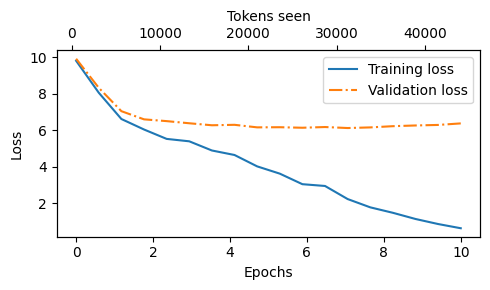

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# **Decoding Strategies to control Randomness**

In [ ]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




**Strategy1: Temprature Scaling**

In [ ]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

In [ ]:
#assume the LLM is given the start context "every effort moves you" and generates the following next-token logits:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [ ]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [ ]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# Temperature values
temperatures = [1, 0.1, 5]  # Original, higher confidence, and lower confidence

# Calculate scaled probabilities
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

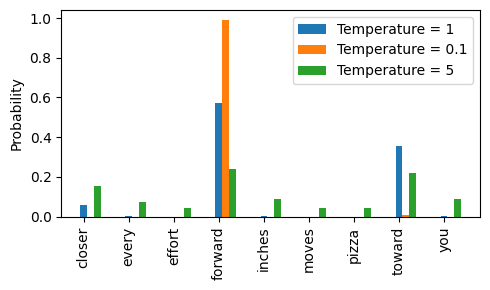

In [ ]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

**Strategy2: Top-K Sampling**

In [ ]:
next_token_logits = torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [ ]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)
print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100])
Top positions: tensor([3, 7, 0])


In [ ]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [ ]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


**Merging Tmeprature Scaling and Top-K Sampling**

In [ ]:
#logits -> Top-k -> Logits/Temp -> softmax -> Sample from multinomial
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"
His up surprise. And whenever his glory, when by his head


# **Loading and Saving Model Weights**

In [ ]:
model = GPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(),"model.pth")  #.pth is convention for pytorch file

In [ ]:
model=GPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [ ]:
#Also recommended to save optimizer as maintain history of gradients
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict":model.state_dict(),
    "optimizer_statr_dict":optimizer.state_dict()
},
      "model_and_optimizer.pth")

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth")
model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_statr_dict"])
model.train();

# **Loading Pretrained Weights from OpenAI**

In [ ]:
pip install tensorflow>=2.15.0 tqdm>=4.66

In [ ]:
import tensorflow as tf
import tqdm

print("TensorFlow version:", tf.__version__)
print("tqdm version:", tqdm.__version__)

TensorFlow version: 2.19.0
tqdm version: 4.67.1


In [ ]:
from gpt_download3 import download_and_load_gpt2

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 172kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 3.04MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys()) #These 5 param keys

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [ ]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True}) #Though Bias model are not used today any more!
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
#using OpenAI's model weights is to override these random weights with the weights ,we loaded into the params dictionary.
#two tensors or arrays (left and right) have the same dimensions or shape and returns the right tensor as trainable PyTorch parameters
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1) #b is the block no. of transformer
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"]) #beac weight tying used in gpt-2



In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.45
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle
